In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline

import dipy.data as dpd
import dipy.core.sphere as dps 
import dipy.sims as sims
import dipy.core.gradients as grad
import dipy.core.geometry as geo
import nibabel as nib

import analysis as ana

In [2]:
fdata, fbval, fbvec = dpd.get_data()
gtab = grad.gradient_table(fbval, fbvec)
gtab.bvals = gtab.bvals/1000. # Make the units work out

/Users/arokem/anaconda3/envs/py2/lib/python2.7/site-packages/dipy/core/gradients.py:132: RuntimeWarning: invalid value encountered in less_equal
  bvecs_close_to_1 = abs(vector_norm(bvecs) - 1) <= atol


In [3]:
data_ni = nib.load(fdata)

In [4]:
data_ni

In [5]:
data = data_ni.get_data()

In [6]:
sph1 = dpd.get_sphere()
#sph1 = dps.Sphere(xyz=[[1,0,0], [0,1,0], [0,0,1]])

In [7]:
dm = ana.design_matrix(gtab, sph1, evals=np.array([1, 0.5, 0.5]))

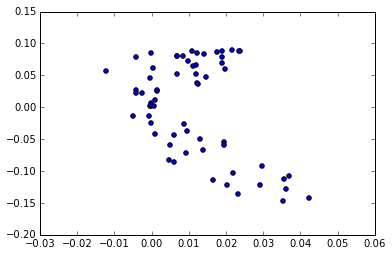

In [8]:
plt.scatter(dm[1][:, 1], dm[0][:, 1])

In [9]:
pp_sig = ana.preprocess_signal(data, gtab, 5, 5, 5)

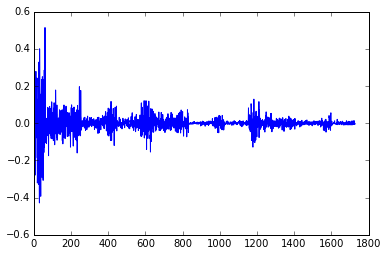

In [10]:
plt.plot(np.concatenate(pp_sig))

In [11]:
new_dm = np.concatenate(dm)
new_sig = np.concatenate(pp_sig)

In [12]:
import sklearn.linear_model as ElasticNet

In [13]:
beta, rnorm = opt.nnls(new_dm, new_sig)

In [14]:
new_dm.shape, new_sig.shape

((1728, 362), (1728,))

In [15]:
y_hat = np.dot(new_dm, beta)

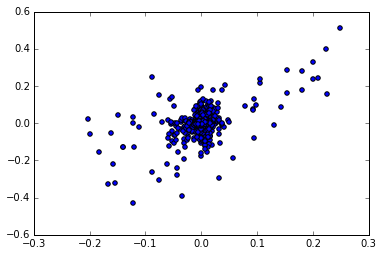

In [16]:
plt.scatter(y_hat, new_sig)

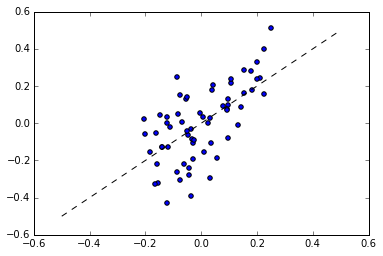

In [17]:
plt.scatter(y_hat[:64], new_sig[:64])
plt.plot([-0.5, 0.5], [-0.5, 0.5], 'k--')

In [18]:
beta_non, rnorm = opt.nnls(new_dm[:64], new_sig[:64])

In [19]:
y_hat_non = np.dot(new_dm, beta_non)

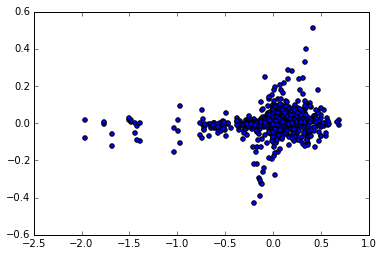

In [20]:
plt.scatter(y_hat_non, new_sig)

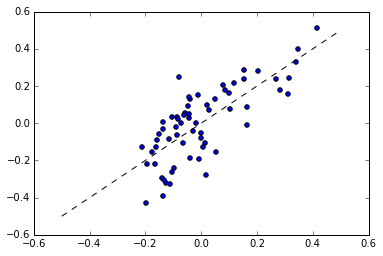

In [21]:
plt.scatter(y_hat_non[:64], new_sig[:64])
plt.plot([-0.5, 0.5], [-0.5, 0.5], 'k--')

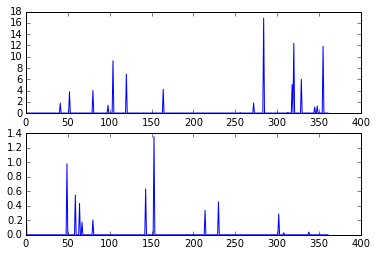

In [22]:
fig, ax = plt.subplots(2)
ax[0].plot(beta_non)
ax[1].plot(beta)

In [25]:
np.sum(beta_non), np.sum(beta)

(87.720597016959118, 6.0758216677533303)